In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

In [9]:
URL = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'
data = pd.read_csv(URL)

cols = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']

df = data[cols]

df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

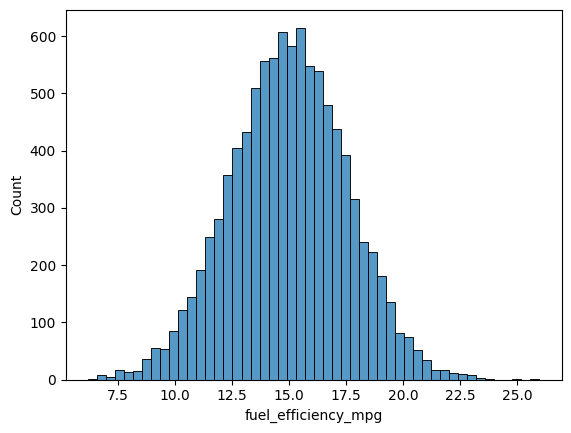

In [10]:
sns.histplot(df.fuel_efficiency_mpg, bins=50)

### Question 1

In [11]:
missing_values = df.isnull().sum()

missing_values[missing_values>0]

horsepower    708
dtype: int64

### Question 2

In [12]:
df.horsepower.describe().loc['50%']

np.float64(149.0)

### Preparing dataset

In [13]:
n = len(df)

n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n - n_val - n_test

In [14]:
n, n_val+n_test+n_train

(9704, 9704)

In [15]:
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)
idx

array([ 483, 7506, 8795, ..., 5390,  860, 7270], shape=(9704,))

#### Missing Values - Fill 0

In [16]:
df_train =  df.iloc[idx[:n_train]]
df_val =  df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [17]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [18]:
y_train  = np.log1p(df_train.fuel_efficiency_mpg.values)
y_test  = np.log1p(df_test.fuel_efficiency_mpg.values)
y_val  = np.log1p(df_val.fuel_efficiency_mpg.values)

In [19]:
del df_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [21]:
base = list(df_train.columns)

X_train = df_train[base].values

X_train = df_train[base].fillna(0).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

<Axes: ylabel='Count'>

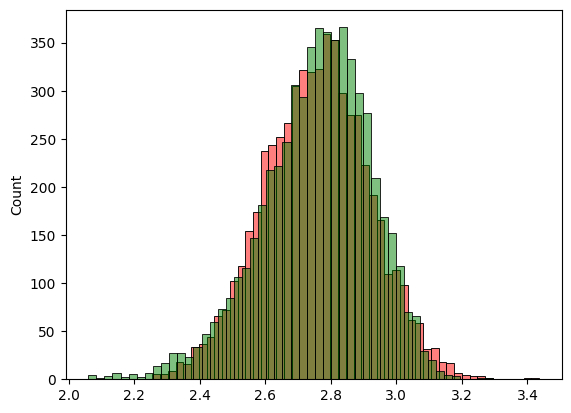

In [22]:
sns.histplot(y_pred, color= 'red',alpha=0.5, bins = 50)
sns.histplot(y_train, color = 'green',alpha=0.5, bins = 50)

In [23]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [24]:
rmse(y_train,y_pred)

np.float64(0.039086325392652485)

In [25]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [26]:
X_train = prepare_X(df_train)

w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)

y_pred = w0 + X_val.dot(w)

with_zero = rmse(y_val,y_pred)
with_zero

np.float64(0.039979257825777034)

#### Missing values filled in with the mean

In [27]:
feature_means = df_train[base].mean()

base = list(df_train.columns)

X_train = df_train[base].values

X_train = df_train[base].fillna(feature_means).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

In [28]:
X_train = prepare_X(df_train)

w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)

y_pred = w0 + X_val.dot(w)

with_mean = rmse(y_val,y_pred)

with_mean

np.float64(0.039979257825777034)

### Question 3

In [29]:
(round(with_zero,2),round(with_mean,2))

(np.float64(0.04), np.float64(0.04))

### Question 4

In [30]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [31]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    base = list(df_train.columns)

    X_train = df_train[base].values

    X_train = df_train[base].fillna(0).values

    X_train = prepare_X(df_train)

    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)

    y_pred = w0 + X_val.dot(w)

    score = round(rmse(y_val,y_pred),2)

    print(f'r:{r}, rmse:{score}')

r:0, rmse:0.04
r:0.01, rmse:0.04
r:0.1, rmse:0.04
r:1, rmse:0.04
r:5, rmse:0.04
r:10, rmse:0.04
r:100, rmse:0.04


### Question 5

In [32]:
base = list(df.columns.drop('fuel_efficiency_mpg', errors='ignore'))
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X


for seed in seeds:
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]
    

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    
  
    y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
    y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
    

    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    
   
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
  
    rmse_scores.append(score)


std_dev = np.std(rmse_scores)


final_answer = round(std_dev, 3)

print(f"rmse: {rmse_scores}")
print(f"std: {std_dev}")
print(f"std (rounded to 3 decimals): {final_answer}")

rmse: [np.float64(0.03801775537080148), np.float64(0.03927885333921255), np.float64(0.03944653052537959), np.float64(0.038727637037731855), np.float64(0.03727535850054727), np.float64(0.03938438834004637), np.float64(0.03890763931360936), np.float64(0.03837971626977783), np.float64(0.04018986975230982), np.float64(0.03860764644229973)]
std: 0.0007799236944796668
std (rounded to 3 decimals): 0.001


### Question 6

In [36]:

n = len(df)

n_val = int(n*0.2)
n_test = int(n*0.2)
n_train = n - n_val - n_test

seed = 9
np.random.seed(seed)
idx = np.arange(n)
np.random.shuffle(idx)


df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)


y_train = np.log1p(df_train.fuel_efficiency_mpg.values)
y_val = np.log1p(df_val.fuel_efficiency_mpg.values)
y_test = np.log1p(df_test.fuel_efficiency_mpg.values)


df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
y_full_train = np.concatenate([y_train, y_val])



X_full_train = prepare_X(df_full_train)
r = 0.001 


w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=r)



X_test = prepare_X(df_test)


y_pred = w0 + X_test.dot(w)


final_rmse = rmse(y_test, y_pred)

print(f"rmse on the test dataset (Seed 9, r=0.001): {final_rmse}")

print(f"final rmse (rounded to 3 decimals): {round(final_rmse, 3)}")


rmse on the test dataset (Seed 9, r=0.001): 0.039196136444522876
final rmse (rounded to 3 decimals): 0.039
